Importing necesary libraries
- pandas - for different opeations with tables
- numpy - numeric calculations
- matplotlib and seaborn for plots
- re - regular expressions
- os - filesystem operations
- natsort - sorting of data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from natsort import index_natsorted

Lists with group and time marks and corresponding lists of well labels

In [4]:
groups = ['Control','1_group','2_group','3_group','4_group','blank']
times = ['None','0hr','4hr','8hr','20hr','24hr','28hr','32hr','44hr','48hr']

labels_groups= [['B2','C2','D2','E2','F2','G2'],
['B3','B4','B5','B6','B7','B8','B9','B10','B11'],
['C3','C4','C5','C6','C7','C8','C9','C10','C11'],
['D3','D4','D5','D6','D7','D8','D9','D10','D11'],
['E3','E4','E5','E6','E7','E8','E9','E10','E11'],
['F3','G3']]


labels_times = [['B2','C2','D2','E2','F2','G2','F3','G3'],
['B3', 'C3', 'D3', 'E3'],
['B4', 'C4', 'D4', 'E4'],
['B5', 'C5', 'D5', 'E5'],
['B6', 'C6', 'D6', 'E6'],
['B7', 'C7', 'D7', 'E7'],
['B8', 'C8', 'D8', 'E8'],
['B9', 'C9', 'D9', 'E9'],
['B10', 'C10', 'D10', 'E10'],
['B11', 'C11', 'D11', 'E11']]

Creating some functions
- image_name_to_label - get image name as a string "_Blue_000_B10." and extract well label (B10) with help of regexp
- image_label_to_group and image_label_to_time functions map labels (B10) to list and return group (1group) and time (44h)

In [5]:

def image_name_to_label(image_path):
    image_name = os.path.basename(image_path)
    image_name_str = str(image_name)
    well_name_re = re.search(r'([B-G]\d{1,2})',image_name_str)

    return well_name_re[0]

def image_label_to_group(well_label):
    for i,group in enumerate(labels_groups):
        for y,value in enumerate(group):
            if well_label in value:
                index_g = i
                
    group_label = groups[index_g]

    return(group_label)

def image_label_to_time(well_label):
    for i,group in enumerate(labels_times):
        for y,value in enumerate(group):
            if well_label in value:
                index_t = i

    time_label = times[index_t]

    return(time_label)



Paths to datafiles in .csv

In [7]:
path_nuclei = "C:/Users/Modern/Desktop/Kirill/Counted_3/MyExpt_Nucleus_filtered.csv"
path_focii = "C:/Users/Modern/Desktop/Kirill/Counted_3/MyExpt_H2AX_in_nucleus.csv"
path_focii_desc = "C:/Users/Modern/Desktop/Kirill/Counted_3/MyExpt_Masked_H2AX.csv"
path_image_data = "C:/Users/Modern/Desktop/Kirill/Counted_3/MyExpt_Image.csv"


Load .csv as pandas dataframes

In [8]:
nuclei_pd=pd.read_csv(path_nuclei)
focii_pd=pd.read_csv(path_focii)
focii_desc_pd = pd.read_csv(path_focii_desc)
image_data_pd=pd.read_csv(path_image_data)


Extract dataframes labels for convenience

In [11]:
labels_nuclei = nuclei_pd.head()
labels_focii = focii_pd.head()
labels_image_data = image_data_pd.head()
labels_path_focii_desc = focii_desc_pd.head()

# print(labels_nuclei)


Create dataframe with correspondence between well label, group and time

In [12]:
labels = image_data_pd['URL_Dapi'].apply(image_name_to_label)

labels_df = pd.DataFrame(labels)

well_group = labels_df['URL_Dapi'].apply(image_label_to_group)
well_time = labels_df['URL_Dapi'].apply(image_label_to_time)

labels_df["Group"] = well_group
labels_df["Time"] = well_time


labels_df = labels_df.join(image_data_pd['ImageNumber'])
labels_df = labels_df.rename(columns={'URL_Dapi':'Well_Name'})

# print(labels_df)

Summ individual foci for each nucleus 

In [19]:
foci_image_corr = focii_desc_pd[['ImageNumber','ObjectNumber','Parent_Nucleus_filtered']].copy()
foci_data = focii_pd[['ImageNumber','ObjectNumber','Intensity_IntegratedIntensity_Red']].copy()

nuclei_pd_numbers = nuclei_pd[['ImageNumber','Children_Masked_H2AX_Count','Intensity_IntegratedIntensity_Red']].copy()

foci_data_image_corr = pd.merge(foci_image_corr,foci_data, how='left',
                                left_on=['ImageNumber','ObjectNumber'],right_on=['ImageNumber','ObjectNumber'])

foci_integrated_intensity_summs = foci_data_image_corr.groupby(['ImageNumber','Parent_Nucleus_filtered'])['Intensity_IntegratedIntensity_Red'].sum()


# print(foci_integrated_intensity_summs)

Join dataframes with data and with labels

In [20]:
foci_data_w_labels = pd.merge(foci_integrated_intensity_summs,labels_df,how='left',
                         left_on=['ImageNumber'],right_on=['ImageNumber'])

nuclei_numbers_w_labels = pd.merge(nuclei_pd_numbers,labels_df,how='left',
                         left_on=['ImageNumber'],right_on=['ImageNumber'])


# print(foci_data_w_labels)



Count nucleus per group and plot corresponding hystplot 

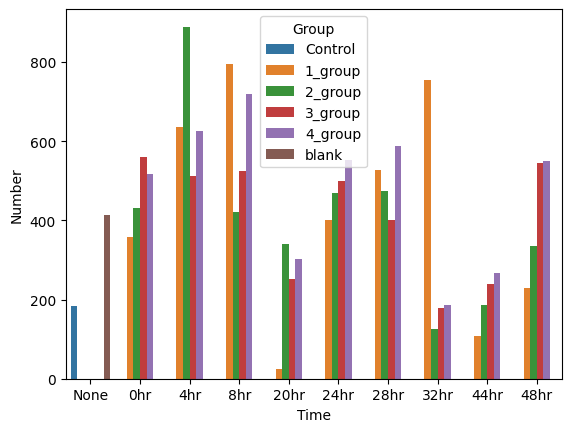

In [15]:
nucleus_count = []

for group in groups:
    for time in times:

        if (group == 'Control') or (group == 'blank'):
            time = 'None'

        count = len(nuclei_numbers_w_labels[(nuclei_numbers_w_labels['Group']==group) & (nuclei_numbers_w_labels['Time']==time) ])
        nucleus_count.append([group,time,count])


#Drop duplicates and empty values
nucleus_count_df = pd.DataFrame(nucleus_count,columns=['Group', 'Time', 'Number'])
nucleus_count_df = nucleus_count_df.drop_duplicates()
nucleus_count_df = nucleus_count_df[nucleus_count_df['Number'] != 0]

ax = sns.barplot(data=nucleus_count_df , x = nucleus_count_df['Time'], y =nucleus_count_df['Number'] , hue =nucleus_count_df['Group'] )

# print(nucleus_count_df)


Total red channel intensity in the nuclei, together with the graph given for control intensity

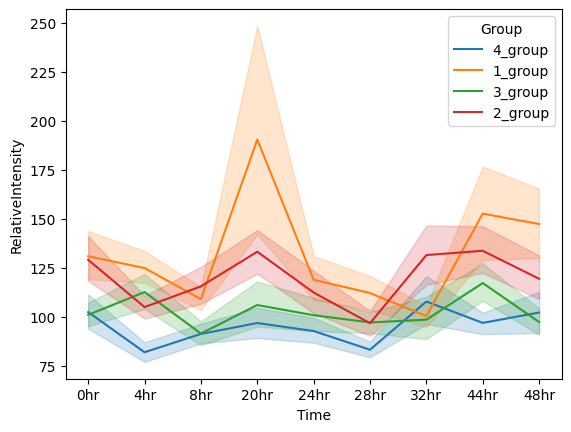

In [39]:

data_nc = nuclei_numbers_w_labels.copy()
nucleus_red_control = data_nc[data_nc['Group'] == 'Control']
nucleus_red_control_mean = nucleus_red_control['Intensity_IntegratedIntensity_Red'].mean()
data_nc = data_nc[data_nc['Group']!='Control']
data_nc = data_nc[data_nc['Group']!='blank']
data_nc = data_nc[data_nc['Time']!='None']


sorterIndex = dict(zip(times, range(len(times))))
foci_data_w_labels['Time_sort'] = nuclei_numbers_w_labels['Time'].map(sorterIndex)

nuclei_numbers_w_labels['Time_sort'] = nuclei_numbers_w_labels['Time'].map(sorterIndex)

nuclei_numbers_w_labels.sort_values(['Time_sort'],
        ascending = [True], inplace = True)

data_nc['RelativeIntensity'] = data_nc['Intensity_IntegratedIntensity_Red']/nucleus_red_control_mean*100

ax = sns.lineplot(data = data_nc,x = 'Time',  
                  y = 'RelativeIntensity', hue='Group') 
# print(data_nc)


Plot mean intensity of foci per group and per time

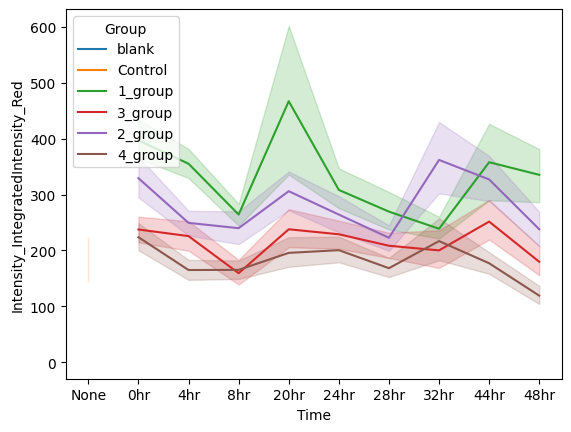

In [12]:
sorterIndex = dict(zip(times, range(len(times))))


foci_data_w_labels['Time_sort'] = foci_data_w_labels['Time'].map(sorterIndex)

foci_data_w_labels.sort_values(['Time_sort'],
        ascending = [True], inplace = True)

ax = sns.lineplot(data = foci_data_w_labels,x = 'Time',  
                  y = 'Intensity_IntegratedIntensity_Red', hue='Group')



Plot absolute quantity of focii per group

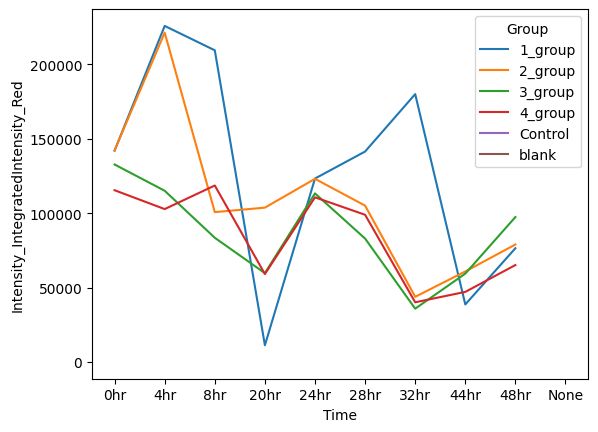

In [13]:

sums_foci_intensity = foci_data_w_labels.groupby(['Group','Time_sort','Time'])['Intensity_IntegratedIntensity_Red'].sum()
sums_foci_intensity_df = pd.DataFrame(sums_foci_intensity)

ax = sns.lineplot(data = sums_foci_intensity_df,x = 'Time',  
                  y = 'Intensity_IntegratedIntensity_Red', hue='Group')


Plot relative to control focii number per group

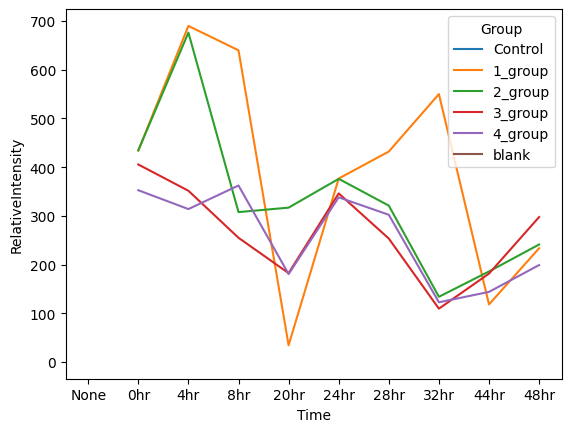

In [14]:
means_foci_intensity = foci_data_w_labels.groupby(['Group','Time_sort','Time'])['Intensity_IntegratedIntensity_Red'].mean()
means_foci_intensity_df = pd.DataFrame(sums_foci_intensity)
means_foci_intensity_df['STD'] = foci_data_w_labels.groupby(['Group','Time_sort','Time'])['Intensity_IntegratedIntensity_Red'].std()

foci_mean_intensity_w_nucleus_number = pd.merge(nucleus_count_df,means_foci_intensity_df,how='left',
                                left_on=['Group','Time'],right_on=['Group','Time'])

#Drop empty rows
foci_mean_intensity_w_nucleus_number = foci_mean_intensity_w_nucleus_number[foci_mean_intensity_w_nucleus_number['Number'] != 0]

foci_mean_intensity_w_nucleus_number_pd = pd.DataFrame(foci_mean_intensity_w_nucleus_number)
control_mean_instensity_df = foci_mean_intensity_w_nucleus_number_pd[foci_mean_intensity_w_nucleus_number_pd['Group'] == 'Control']

control_mean_instensity = control_mean_instensity_df.iloc[0]['Intensity_IntegratedIntensity_Red']


foci_mean_intensity_w_nucleus_number_pd['RelativeIntensity'] = foci_mean_intensity_w_nucleus_number_pd['Intensity_IntegratedIntensity_Red']/control_mean_instensity*100
foci_mean_intensity_w_nucleus_number_pd['RelativeSTD'] =  foci_mean_intensity_w_nucleus_number_pd['STD']/control_mean_instensity*100

# print(foci_mean_intensity_w_nucleus_number_pd)  

ax = sns.lineplot(data = foci_mean_intensity_w_nucleus_number,x = 'Time',  
                  y = 'RelativeIntensity', hue='Group')

# print(foci_mean_intensity_w_nucleus_number_pd['RelativeSTD'])

# ax.set(xlabel='Time', ylabel='Relative to control intensity,%')



Plot relative to control intensity with error bars

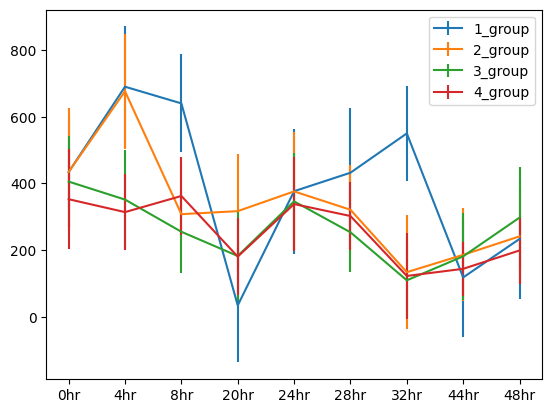

In [28]:
data = foci_mean_intensity_w_nucleus_number.copy()
data = data[data['Group']!='Control']
data = data[data['Group']!='blank']
data = data[data['Time']!='None']
data = data.dropna(how='all')
# print(data)

times_red = ['0hr','4hr','8hr','20hr','24hr','28hr','32hr','44hr','48hr']
groups_red = ['1_group','2_group','3_group','4_group']
data['STD_div'] = data['STD']/2


for g in groups_red:
    y = data['RelativeIntensity'][data['Group']==g].to_list()
    e = data['STD_div'][data['Group']==g].to_list()
    ax = plt.errorbar(times_red,y,e)
plt.legend(groups_red)

Intensities with respect for the number of cells in the group

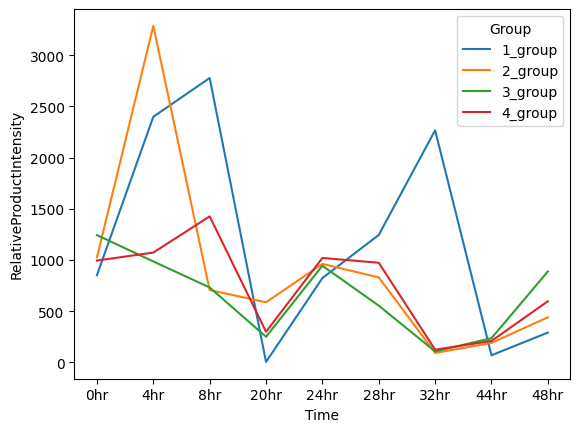

In [30]:




foci_mean_intensity_w_nucleus_number['ProductIntensity'] = foci_mean_intensity_w_nucleus_number_pd['Intensity_IntegratedIntensity_Red']*foci_mean_intensity_w_nucleus_number_pd['Number']

control_product_intensity_pd = foci_mean_intensity_w_nucleus_number[foci_mean_intensity_w_nucleus_number['Group'] == 'Control']

control_product_intensity = control_product_intensity_pd.iloc[0]['ProductIntensity']

foci_mean_intensity_w_nucleus_number['RelativeProductIntensity'] = foci_mean_intensity_w_nucleus_number['ProductIntensity'] / control_product_intensity * 100

data_product = foci_mean_intensity_w_nucleus_number.copy()
data_product = data_product[data_product['Group']!='Control']
data_product = data_product[data_product['Group']!='blank']
data_product = data_product[data_product['Time']!='None']


ax = sns.lineplot(data = data_product,x = 'Time',  
                  y = 'RelativeProductIntensity', hue='Group')


Distribution of focii number per nucleus. You can change time-group in this part *"(foci_data_w_labels['Time'] == "0hr")"*

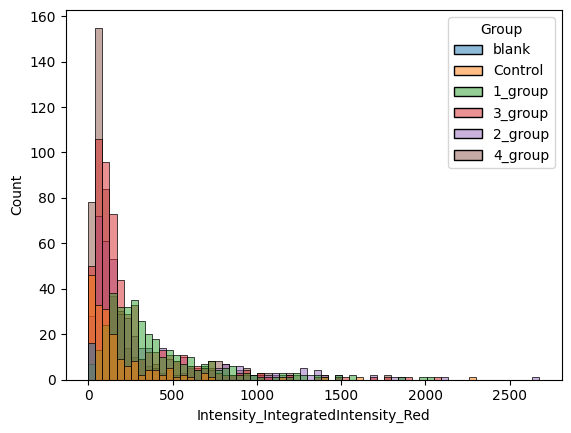

In [925]:

rslt_df = foci_data_w_labels[(foci_data_w_labels['Time'] == "0hr") | (foci_data_w_labels['Time'] == "None")]


ax = sns.histplot(data=rslt_df, x=rslt_df['Intensity_IntegratedIntensity_Red'],hue='Group')
